<a href="https://colab.research.google.com/github/Sunnykumar1554/Ad-s-/blob/main/airflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!apt-get -qq update && apt-get -qq install -y graphviz
!pip -q install graphviz

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


In [2]:
import time
from graphviz import Digraph
from IPython.display import display, clear_output

In [3]:
def show(dot, title=None):
  clear_output(wait=True)
  if title: print(title)
  display(dot)

In [4]:
def extract():
  print("[Extract] pulling data....")
  time.sleep(1.5)
  print("[Extract] dome")

def transform():
  print("[Transform] pulling data....")
  time.sleep(2.0)
  print("[Transform] dome")

def load():
  print("[Load] pulling data....")
  time.sleep(1.0)
  print("[Load] dome")

def qc():
  print("[qc] pulling data....")
  time.sleep(0.5)
  print("[qc] dome")



In [5]:
# creating DAG file

# DAG structure   -> { task_id -> fn: callable , upstream [ids], state:str };


dag={
    "extract": {"fn":extract,"upstream":[],"state":"None"},
    "transform": {"fn":transform,"upstream":["extract"],"state":"None"},
    "load": {"fn":load,"upstream":["transform"],"state":"None"},
    "qc": {"fn":qc,"upstream":["transform"],"state":"None"},
}

In [6]:
# defining color sceame for various process stages

STATE_COLOR={'NONE': "linghtgray","QUEUED": "yellow", "RUNNING": "orange","SUCCESS": "green","FAILED": "red"}

In [7]:
def render(dag):
  dot=Digraph()
  dot.attr(rankdir="LR")


  #nodes
  for tid, info in dag.items():
    label=f"{tid}\\n[{info['state']}]"
    dot.node(tid,label=label,style="filled",fillcolor=STATE_COLOR.get(info["state"]))


  #Edges

  for tid, info in dag.items():
    for up in info['upstream']:
      dot.edge(up,tid)
  return dot

Success qc


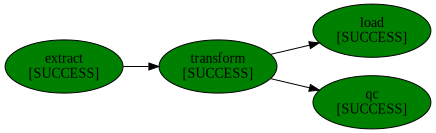


Final States:
 - extract: SUCCESS
 - transform: SUCCESS
 - load: SUCCESS
 - qc: SUCCESS


In [8]:


def topological_order(dag):
  # implementing Kahn's Algo for executing the process of DAG

  in_deg={t: len(info['upstream']) for t,info in dag.items()}
  q=[t for t,d in in_deg.items() if d==0]
  order=[]
  while q:
    n=q.pop(0); order.append(n)
    for m,info in dag.items():
      if n in info['upstream']:
        in_deg[m]-=1
        if in_deg[m]==0: q.append(m)
  return order

# mark roots queued
for t,info in dag.items():
  if not info['upstream']: info['state']="QUEUED"

show(render(dag), "INITIAL DAG (queued roots)")

# run the orders sequerntially in topological order
order=topological_order(dag)
print("Execution Order:",order)

for tid in order:
  # wait until upstream task is not fininshed
  while any(dag[u]['state']!="SUCCESS" for u in dag[tid]['upstream']):
    # if upstream is failed, mark fail and skip
    if any(dag[u]['state']!="FAILED" for u in dag[tid]['upstream']):
      dag[tid]['state']="FAILED"
      print(f"Skipping {tid} because upstream is failed")
      show(render(dag),f"Skipping {tid}")
      break
    time.sleep(0.2)
  if dag[tid]['state']=="FAILED":
    continue

  # run the task
  dag[tid]['state']="RUNNING"; show(render(dag), f"Running {tid}")

  try:
    dag[tid]['fn']()
    dag[tid]['state']="SUCCESS"; show(render(dag), f"Success {tid}")

  except Exception as e:
    dag[tid]['state']="FAILED"
    print(f"RTask {tid} failed:", e)
    show(render(dag), f"Failed {tid}")

print("\nFinal States:")
for t,info in dag.items():
  print(f" - {t}: {info['state']}")